# What does a convolutional network see?

### Prerequisites and Imports

In [28]:
!pip install -U efficientnet
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=3e6416a069a07c5947294b63123504b821a14640207a1cfb0cdf28e7c126ca2f
  Stored in directory: c:\users\ram\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [179]:
import tensorflow as tf
import numpy as np

import efficientnet.tfkeras as efn
from IPython import display
import wget
from tqdm.auto import tqdm

import albumentations as A


In [37]:

# Function to create our EfficientNetB3 model
def build_EFNv1(rescaling=0, EFF_NET=0, gap=False):
    import efficientnet.tfkeras as efn

    EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3,
            efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

    InputSizes = [224, 240, 260, 300, 380, 456, 528, 600]

    model_name = f'effnetv1_b{EFF_NET}'

    print(model_name)

    sz = InputSizes[EFF_NET]

    #inp = tf.keras.layers.Input(shape=[config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name='inp1')
    #inp = tf.keras.layers.Input(shape=[None, None, 3], name='inp1')
    inp = tf.keras.layers.Input(shape=[sz, sz, 3], name='inp1')

    if rescaling == 255:
        inp = tf.keras.layers.Rescaling(1.0 / 255.0)(inp)
    elif rescaling == 128:
        inp = tf.keras.layers.Rescaling(1.0 / 128.0, offset=-1)(inp)
    elif rescaling == 127:
        inp = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)(inp)

    backbone_model = EFNS[EFF_NET](weights='noisy-student', include_top=False)
    x = backbone_model(inp)
    
    if gap:
        embed = tf.keras.layers.GlobalAveragePooling2D()(x)
    else:
        embed = x

    model = tf.keras.models.Model(inputs=[inp], outputs=[embed])

    return model, backbone_model, inp, embed, model_name


def read_and_decode_image(file_path):
    img = tf.io.read_file(file_path)
    #img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.io.decode_jpeg(img, channels=3)
    return img



### Build backbone

In [343]:

_, model, input, _, model_name = build_EFNv1(EFF_NET=0, rescaling=255)
resizing_layer = tf.keras.layers.Resizing(input.shape[1], input.shape[2])

model.summary()

effnetv1_b0
Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_13[0][0]']               
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                     

### Get image, display, resize

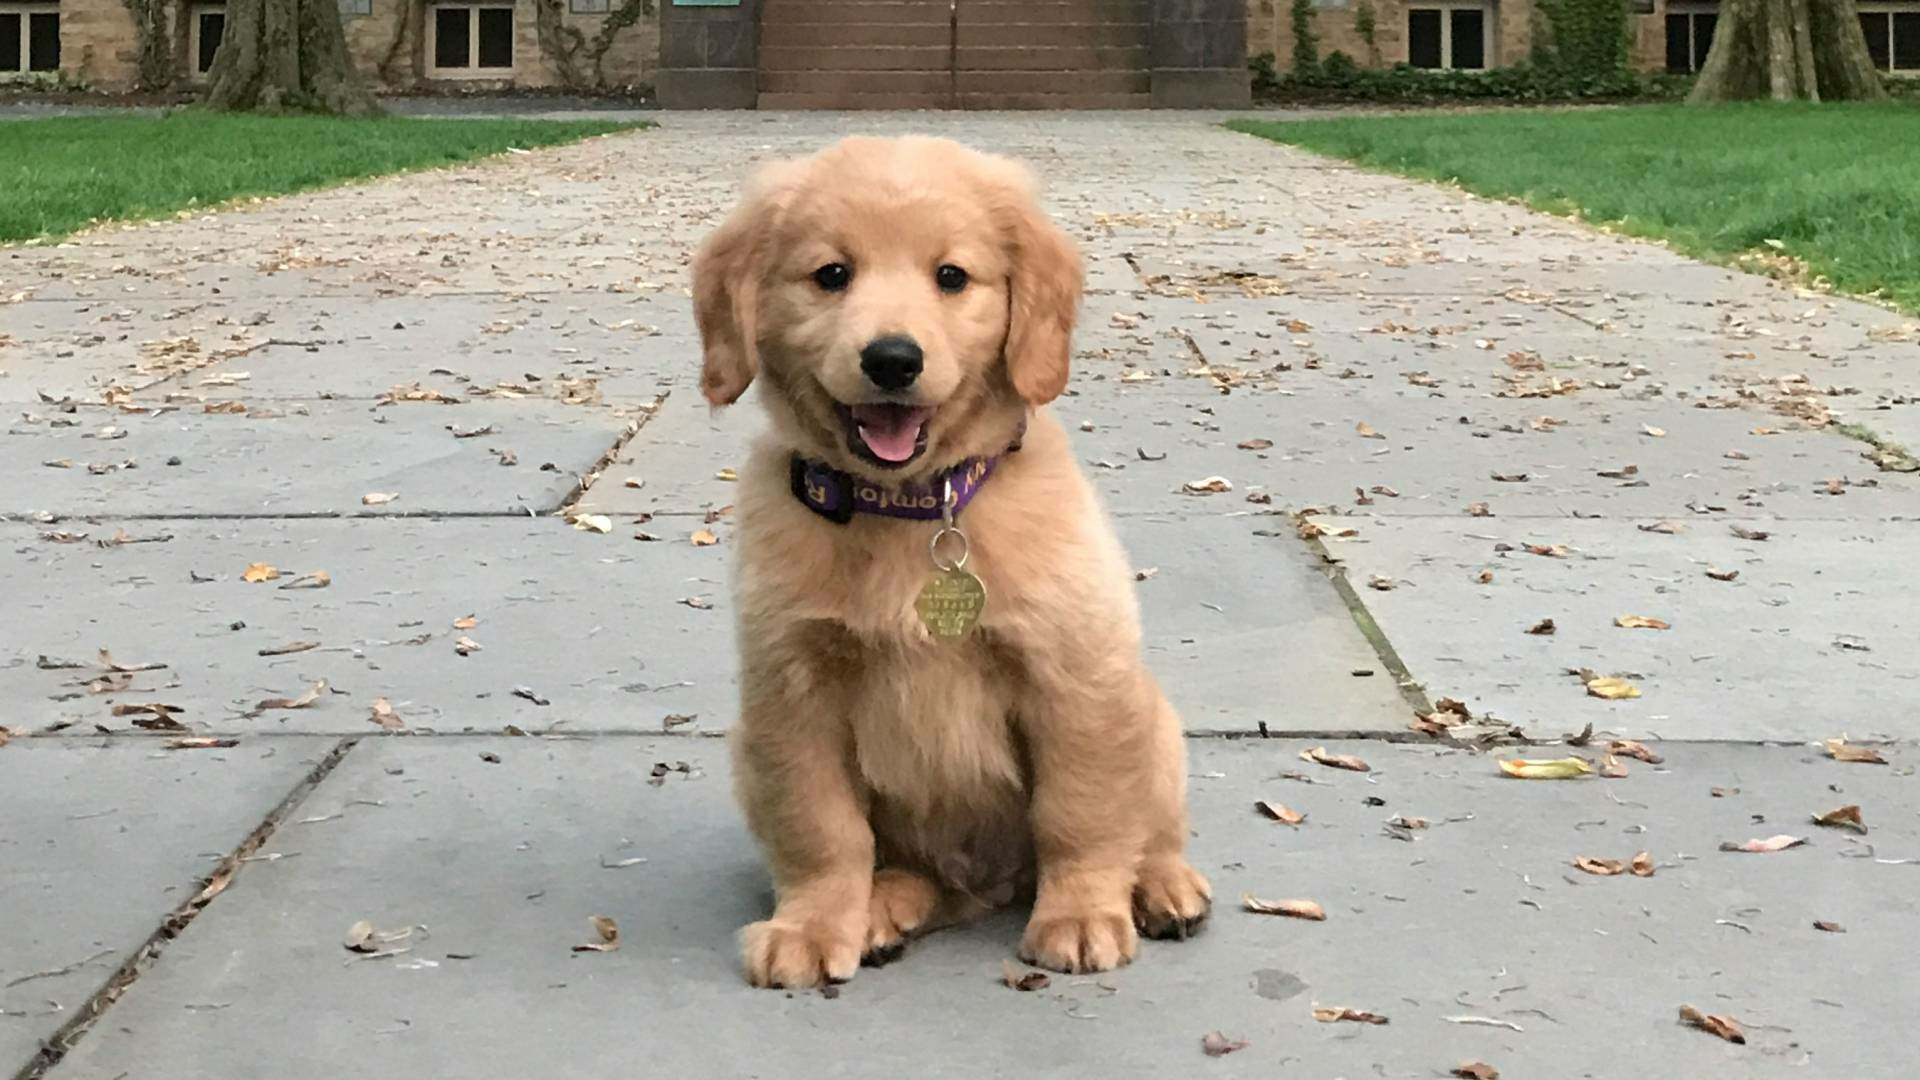

In [349]:
import requests
import matplotlib.pyplot as plt


image_url = 'https://www.princeton.edu/sites/default/files/styles/half_2x/public/images/2022/02/KOA_Nassau_2697x1517.jpg'
r = requests.get(image_url, allow_redirects=False)

I0 = tf.io.decode_jpeg(r.content, channels=3)

def display_image(I):
    return display.Image(data=tf.io.encode_png(I).numpy(), format='png')

#wget.download(image_url, 'image')
#image_object = display.Image('image', width=224, height=224)
def display_image_alt(I, sz=(10, 7)):
    fig = plt.figure(figsize=sz)
    plt.grid(False)
    plt.imshow(I)
    plt.show()

display_image(I0)

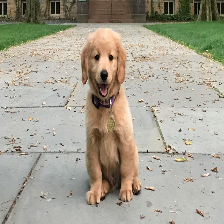

In [241]:
I_resized = tf.image.resize(I0, (input.shape[1], input.shape[2]))

display_image(I_resized.numpy().astype(dtype=np.uint8))

### Construct model with intermediate output

In [389]:




#selected_layer = 204 # try 11, 204, block3b_activation 
#selected_layer = model.layers[selected_layer]

selected_layer = model.get_layer('block7a_se_excite') # try block2a_activation , block2b_activation , block3b_activation, block4a_activation , block7a_se_excite , top_activation 

print(selected_layer.name)

intermediate_model = tf.keras.models.Model(inputs=model.inputs, outputs=[selected_layer.output])
intermediate_model.trainable = False # Set as untrainable

#intermediate_model.summary()

I = tf.expand_dims(I_resized, axis=0) / 255
target_output = intermediate_model(I)


block7a_se_excite


tf.Tensor(0.08028535, shape=(), dtype=float32)
tf.Tensor(0.014122831, shape=(), dtype=float32)
tf.Tensor(0.054289944, shape=(), dtype=float32)
tf.Tensor(0.07020686, shape=(), dtype=float32)
tf.Tensor(0.055516332, shape=(), dtype=float32)


  0%|          | 0/500 [00:00<?, ?it/s]

tf.Tensor(0.010558453, shape=(), dtype=float32)


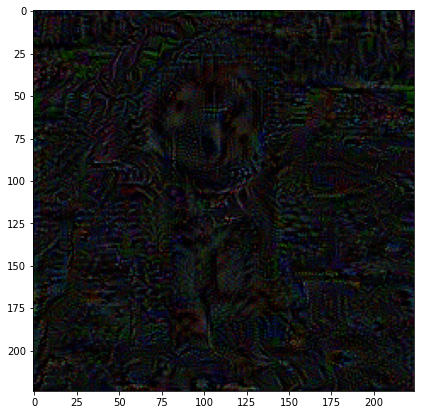

  0%|          | 0/500 [00:00<?, ?it/s]

tf.Tensor(0.0063010626, shape=(), dtype=float32)


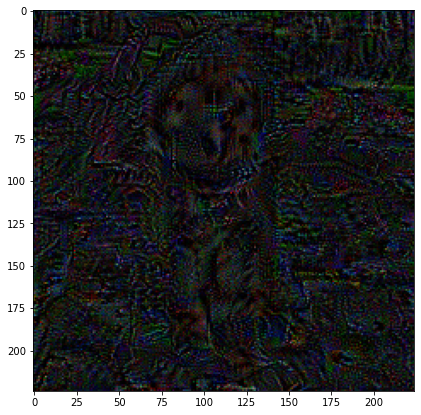

  0%|          | 0/500 [00:00<?, ?it/s]

tf.Tensor(0.00438135, shape=(), dtype=float32)


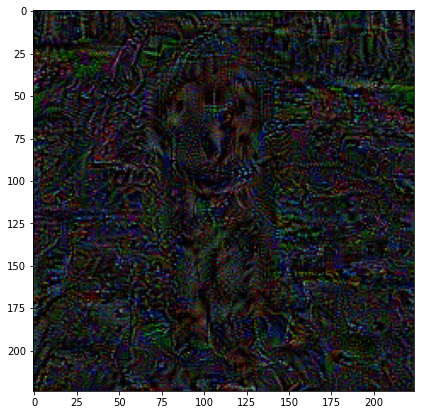

  0%|          | 0/500 [00:00<?, ?it/s]

tf.Tensor(0.003594204, shape=(), dtype=float32)


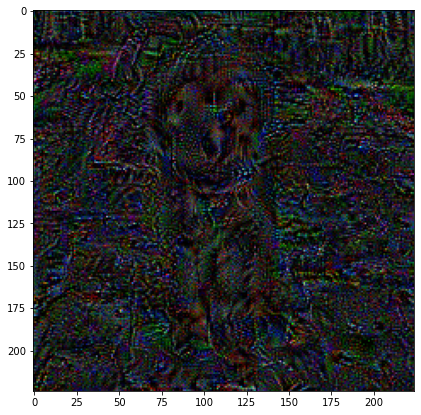

  0%|          | 0/500 [00:00<?, ?it/s]

tf.Tensor(0.0031068043, shape=(), dtype=float32)


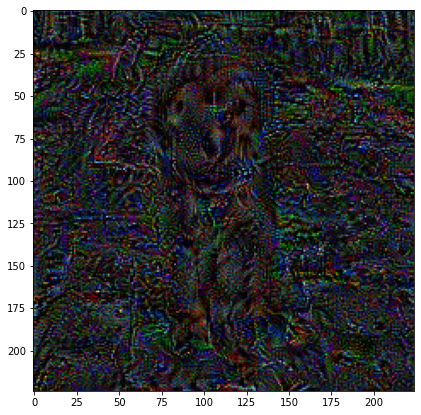

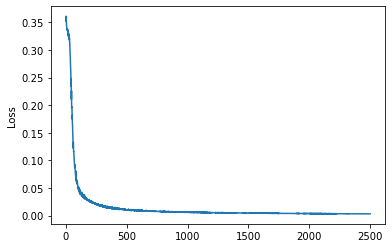

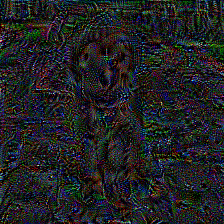

In [390]:
# Initialize a trainable input
trained_input_initial = tf.random.uniform(shape=I.shape)
trained_input_initial = tf.zeros(shape=I.shape)
trained_input = tf.Variable(initial_value=trained_input_initial, dtype=tf.float32, trainable=True)

#loss_fun = tf.keras.losses.MeanAbsoluteError()
loss_fun = tf.keras.losses.MeanSquaredError()
#loss_fun = lambda x, y : tf.math.reduce_mean(tf.math.pow(tf.math.abs(x - y), 4.0), axis=(1, 2, 3))

noise_generator = A.Compose([
    A.GaussNoise(var_limit=0.01, p=1.0),
    #A.Blur(blur_limit=3, p=1.0),
    #A.HueSaturationValue(),
])

for sample in range(5):
    #I_noisy = (I + 50 * tf.random.normal(shape=I.shape))
    #I_noisy = tf.clip_by_value(I_noisy, 0.0, 255.0)
    #I_noisy = I_noisy.numpy()
    I_noisy = noise_generator(image=I.numpy())['image']
    
    output = intermediate_model(I_noisy)
    loss = loss_fun(target_output, output)
    #display_image_alt(I_noisy[0].astype(dtype=np.uint8), sz=(5, 3))
    print(loss)

#x = np.arange(0, input.shape[1])
x = np.arange(0, target_output.shape[1])
x, y = np.meshgrid(x, x)
mask = np.expand_dims((x < 50) * (y < 50), axis=(0, 3))
mask = tf.convert_to_tensor(mask, dtype=tf.float32)

method = 0
loss_list = []

for epoch in range(5):
    #trained_input = trained_input + 0.02 * tf.random.normal(shape=trained_input.shape)
    for iteration in tqdm(range(500)):

        #tf_image = tf.convert_to_tensor(I, dtype='float32')

        with tf.GradientTape() as tape:
            tape.watch(trained_input)
            output = intermediate_model(trained_input)

            loss = loss_fun(target_output, output)

        input_grad = tape.gradient(loss, trained_input)
        #input_grad = input_grad.numpy() * mask

        
        # Change each pixel by +/- 1, against the gradient
        eps = 1e-9
        pixels_with_pos_grad = tf.cast(input_grad > eps, 'float32')
        pixels_with_neg_grad = tf.cast(input_grad < -eps, 'float32')

        if method == 0:
            trained_input = trained_input + (pixels_with_neg_grad - pixels_with_pos_grad) / 255.
        else:
            m = tf.math.reduce_max(tf.math.abs(input_grad), axis=(1, 2))

            trained_input = trained_input - (input_grad / m) / 255.
        #if iteration % 300 == 0:
        #    trained_input = trained_input + 0.1 * tf.random.normal(shape=trained_input.shape)
        
        trained_input = tf.clip_by_value(trained_input, 0.0, 1.0)
        loss_list.append(loss)
    print(loss)
    
    I_generated = tf.convert_to_tensor(trained_input)[0] * 255
    display_image_alt(I_generated.numpy().astype(dtype=np.uint8))    
    

plt.plot(loss_list)
plt.ylabel('Loss')
plt.show()

I_generated = tf.convert_to_tensor(trained_input)[0] * 255
display_image(I_generated.numpy().astype(dtype=np.uint8))

In [385]:
# TODO: Compare visual representation retention to vision transformers